# Import libs

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression

# Load data

In [3]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
# load identity data
train_id = pd.read_csv("train_identity.csv")
train_id = reduce_mem_usage(train_id)
print(train_id.head())

Memory usage of dataframe is 45.12 MB --> 25.86 MB (Decreased by 42.7%)
   TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  ...                id_31  id_32      id_33           id_34  id_35  \
0    NaN  ...  samsung browser 6.2   32.0  2220x1080  match_status:2      T   
1    NaN  ...   mobile safari 11.0   32.0   1334x750  match_status:1      T   
2    0.0  ...          chrome 62.0    NaN        NaN             NaN      F   
3    NaN  ...          chrome 62.0    NaN        NaN             NaN      F   
4    0.0  ...          chrome 62.0   24.0   1280x800  matc

In [5]:
train_id.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [6]:
# get categorical columns of identity data (from documentation)
id_catcol = train_id.columns[12:].tolist()
id_catcol

['id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_32',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

In [7]:
# load transaction data
train_ts = pd.read_csv("train_transaction.csv")
train_ts = reduce_mem_usage(train_ts)
print(train_ts.head())

Memory usage of dataframe is 1775.15 MB --> 542.35 MB (Decreased by 69.4%)
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   


In [8]:
train_ts.columns[:70]

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7',
       'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15'],
      dtype='object')

In [9]:
# get categorical columns of transaction data (from documentation)
ts_catcol = train_ts.columns[4:13].tolist() + train_ts.columns[15:17].tolist() + train_ts.columns[46:55].tolist()
ts_catcol

['ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

## Read test data

In [10]:
test_id = pd.read_csv('test_identity.csv')
test_id = reduce_mem_usage(test_id)
test_ts = pd.read_csv('test_transaction.csv')
test_ts = reduce_mem_usage(test_ts)

Memory usage of dataframe is 44.39 MB --> 25.44 MB (Decreased by 42.7%)
Memory usage of dataframe is 1519.24 MB --> 472.59 MB (Decreased by 68.9%)


In [11]:
# find the label column
[c for c in train_ts.columns if c not in test_ts.columns]

['isFraud']

In [12]:
# merge identity and transaction data for both train and test
train = pd.merge(train_ts, train_id, on='TransactionID', how='left')
test = pd.merge(test_ts, test_ts, on='TransactionID', how='left')
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 785 columns.


In [13]:
del train_ts, test_ts, train_id, test_id

In [14]:
print(f'There are {train.isnull().any().sum()} columns in train dataset with missing values.')

There are 414 columns in train dataset with missing values.


# Data Visualization

Normally the fraud detection problem is unbalanced label problem. See if this one is the case.

,0,1
isFraud,0.96501,0.03499


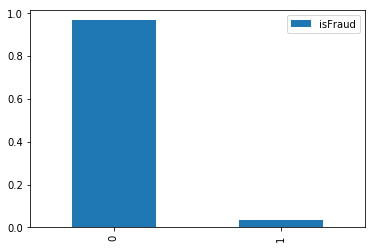

In [15]:
fc = train['isFraud'].value_counts(normalize=True).to_frame()
fc.plot.bar()
fc.T

In addition, it seems that `card4` represents card type. Let's see how often each type of card is fraud.

In [53]:
card4_fraud = train.groupby('card4').sum().unstack()['isFraud']
card4_tot = train.groupby('card4').count().unstack()['isFraud']

In [54]:
card4_fraud.head()

card4
american express      239.0
discover              514.0
mastercard           6496.0
visa                13373.0
dtype: float64

In [55]:
card4_tot.head()

card4
american express      8328
discover              6651
mastercard          189217
visa                384767
dtype: int64

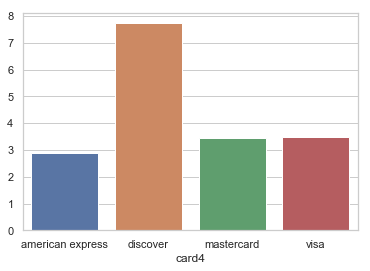

In [69]:
pct_fraud = card4_fraud/card4_tot*100
# plot seaborn
sns.set(style='whitegrid')
sns.barplot(x=pct_fraud.index, y=pct_fraud.values)

# Prediction

Let's get into the prediction. Since it's just a prototype, the accuracy for is not emphasized that much.